<a href="https://colab.research.google.com/github/Lambdaderta/yandex_lms_contest_ResNet/blob/main/Vision_Transformer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

ml_intensive_yandex_academy_spring_2025_path = kagglehub.competition_download('ml-intensive-yandex-academy-spring-2025')

print('Data source import complete.')


100%|██████████| 7.90G/7.90G [03:23<00:00, 41.6MB/s]

Extracting files...


Data source import complete.


# Импорт библиотек

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import numpy as np
from torchsummary import summary
from google.colab import drive
import shutil
import matplotlib.pyplot as plt


# Обработка изображений, работа над классами и датасетом

In [ ]:
import os
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset, WeightedRandomSampler
from torchvision import transforms
from sklearn.model_selection import train_test_split

# Константы
DATA_DIR = "/root/.cache/kagglehub/competitions/ml-intensive-yandex-academy-spring-2025/human_poses_data"
CSV_PATH = os.path.join(DATA_DIR, 'train_answers.csv')
IMG_DIR = os.path.join(DATA_DIR, 'img_train')
TEST_DIR = os.path.join(DATA_DIR, 'img_test')

BASE_TRANSFORM = transforms.Compose([
    transforms.Resize((896, 896)),
    transforms.ToTensor(),
])

AUGMENT_TRANSFORM = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.Resize((896, 896)),
    transforms.ToTensor(),
])



class TrainDataset(Dataset):
    def __init__(self, img_dir, csv_path, transform=None):
        self.img_dir = img_dir
        self.df = pd.read_csv(csv_path)
        self.transform = transform

        # Обработка пропусков в метках
        if self.df.iloc[:, 1].isnull().any():
            most_frequent = self.df.iloc[:, 1].mode()[0]
            self.df.iloc[:, 1] = self.df.iloc[:, 1].fillna(most_frequent)

        self.class_counts = self.df.iloc[:, 1].value_counts()
        sorted_classes = sorted(self.class_counts.index)

        self.class_mapping = {cls: idx for idx, cls in enumerate(sorted_classes)}
        self.reverse_mapping = {v: k for k, v in self.class_mapping.items()}

        self.small_classes = self.class_counts[self.class_counts < 1000].index.tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_id = str(self.df.iloc[idx, 0])
        img_path = os.path.join(self.img_dir, f"{file_id}.jpg")

        image = Image.open(img_path).convert('RGB')
        original_label = self.df.iloc[idx, 1]
        new_label = self.class_mapping[original_label]

        # Базовое преобразование для всех
        image = BASE_TRANSFORM(image)

        return image, new_label

    def reverse_label(self, new_label):
        return self.reverse_mapping[new_label]

# Класс для аугментации малых классов
class AugmentedDataset(Dataset):
    def __init__(self, original_subset):
        self.original_subset = original_subset
        self.original_dataset = original_subset.dataset
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.Resize((896, 896)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.original_subset)

    def __getitem__(self, idx):
        image, label = self.original_subset[idx]

        original_idx = self.original_subset.indices[idx]
        original_label = self.original_dataset.df.iloc[original_idx, 1]

        if original_label in self.original_dataset.small_classes:
            image = transforms.ToPILImage()(image)
            image = self.transform(image)

        return image, label

original_dataset = TrainDataset(IMG_DIR, CSV_PATH)

train_indices, val_indices = train_test_split(
    range(len(original_dataset)),
    test_size=0.2,
    stratify=original_dataset.df.iloc[:, 1].map(original_dataset.class_mapping),
    random_state=42
)

train_subset = Subset(original_dataset, train_indices)
augmented_train = AugmentedDataset(train_subset)

# Объединение оригинальных и аугментированных данных
combined_train = ConcatDataset([train_subset, augmented_train])

# Балансировка через WeightedRandomSampler
class_weights = 1 / torch.sqrt(torch.tensor(original_dataset.class_counts.values, dtype=torch.float))
sample_weights = class_weights[original_dataset.df.iloc[:, 1].map(original_dataset.class_mapping).values][train_indices]

train_loader = DataLoader(
    combined_train,
    batch_size=32,
    sampler=WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(combined_train),
        replacement=True
    ),
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    Subset(original_dataset, val_indices),
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Тестовый датасет
class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_list = os.listdir(img_dir)
        self.transform = transform or BASE_TRANSFORM

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_list[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, -1

test_dataset = TestDataset(TEST_DIR)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Функция обратного преобразования
def convert_predictions(predictions):
    return [original_dataset.reverse_label(pred) for pred in predictions]

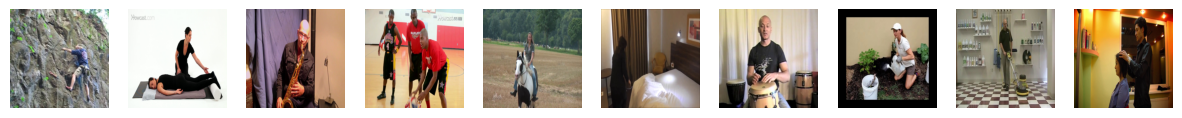

In [ ]:
def show_real_image(dataset, index):
    img, _ = dataset[index]
    plt.imshow(transforms.ToPILImage()(img))
    plt.axis('off')

plt.figure(figsize=(15,3))
for i in range(10):
    plt.subplot(1,10,i+1)
    show_real_image(test_dataset, i)
plt.show()

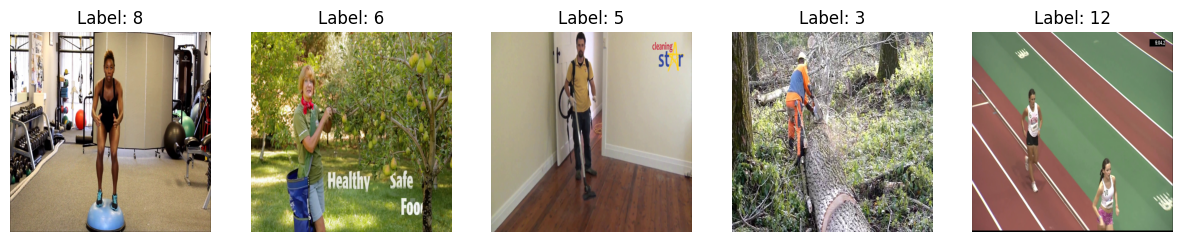

In [ ]:
import matplotlib.pyplot as plt
import random

def show_augmented_examples(dataset, num_examples=5):
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))
    for ax in axes:
        idx = random.randint(0, len(dataset)-1)
        img, label = dataset[idx]
        ax.imshow(transforms.ToPILImage()(img))
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    plt.show()

show_augmented_examples(original_dataset)

In [ ]:
print(f"Original train size: {len(train_indices)}")
print(f"Augmented train size: {len(combined_train)}")
print(f"Validation size: {len(val_indices)}")

Original train size: 9893
Augmented train size: 19786
Validation size: 2474


# Функция обучения

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import shutil

def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=30,
    lr=0.001,
    use_scheduler=True,
    save_path='/content/drive/MyDrive/Colab Models'
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    if use_scheduler:
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    !mkdir -p "{save_path}"

    best_f1 = 0.0
    train_losses, val_losses = [], []
    train_f1, val_f1 = [], []

    for epoch in range(num_epochs):
        print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")

        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []
        print("Training...")
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            if (i + 1) % 50 == 0:
                print(f"Batch {i+1}/{len(train_loader)} completed.")

        if use_scheduler:
            scheduler.step()

        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        print("Validating...")
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        epoch_f1 = f1_score(all_labels, all_preds, average='macro')
        val_loss /= len(val_loader)
        val_epoch_f1 = f1_score(val_labels, val_preds, average='macro')

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_f1.append(epoch_f1)
        val_f1.append(val_epoch_f1)

        if val_epoch_f1 > best_f1:
            best_f1 = val_epoch_f1
            model_path = f'{save_path}/best_model.pth'
            torch.save(model.state_dict(), model_path)
            print(f'New best model saved! F1: {best_f1:.4f}')

        print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
        print(f'Train F1: {epoch_f1:.4f} | Val F1: {val_epoch_f1:.4f}')
        print('-' * 60)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_f1, label='Train F1')
    plt.plot(val_f1, label='Val F1')
    plt.title('F1 Score Curves')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# Реализация Vision Transformer'a для моей задачки

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(
        self,
        dim,
        num_heads,
        mlp_ratio=4.0,
        qkv_bias=True,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
    ):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(
            embed_dim=dim,
            num_heads=num_heads,
            dropout=attn_drop,
            bias=qkv_bias,
            batch_first=True,
        )
        self.drop_path = nn.Identity() if drop_path == 0.0 else nn.Dropout(drop_path)
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(mlp_hidden, dim),
            nn.Dropout(drop),
        )

    def forward(self, x):
        x_res = x
        x = self.norm1(x)
        attn_out, _ = self.attn(x, x, x)
        x = x_res + self.drop_path(attn_out)
        x_res = x
        x = self.norm2(x)
        x = x_res + self.drop_path(self.mlp(x))
        return x

import torch
import torch.nn as nn

class ConvStem(nn.Module):
    def __init__(self, in_channels=3, out_channels=64):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // 2,
                     kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(out_channels // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels // 2, out_channels,
                     kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.stem(x)

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, embed_dim, patch_size=16):
        super().__init__()
        self.proj = nn.Conv2d(
            in_channels, embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        x = self.proj(x)
        B, E, H, W = x.shape
        return x.flatten(2).transpose(1, 2)

class LightHybridViT(nn.Module):
    def __init__(
        self,
        img_size=512,
        in_channels=3,
        num_classes=16,
        embed_dim=128,
        depth=8,
        num_heads=8,
        mlp_ratio=2.0,
        patch_size=32,
        drop_rate=0.3,
        attn_drop_rate=0.2,
    ):
        super().__init__()

        self.conv_stem = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, img_size, img_size)
            features = self.conv_stem(dummy)
            h, w = features.shape[2], features.shape[3]
            self.num_patches = (h // patch_size) * (w // patch_size)

        self.patch_embed = nn.Conv2d(64, embed_dim,
                                    kernel_size=patch_size,
                                    stride=patch_size)

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        self.blocks = nn.Sequential(*[
            TransformerBlock(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
            ) for _ in range(depth)
        ])

        self.head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(p=drop_rate),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        x = self.conv_stem(x)

        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)

        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed
        x = self.pos_drop(x)

        x = self.blocks(x)

        return self.head(x[:, 0])


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LightHybridViT(img_size=512).to(device)
summary(model, (3, 512, 512), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]           4,736
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7            [-1, 128, 4, 4]       8,388,736
           Dropout-8              [-1, 17, 128]               0
         LayerNorm-9              [-1, 17, 128]             256
MultiheadAttention-10  [[-1, 17, 128], [-1, 17, 17]]               0
         Identity-11              [-1, 17, 128]               0
        LayerNorm-12              [-1, 17, 128]             256
           Linear-13              [-1, 17, 256]          33,024
             GELU-14              

In [ ]:
train_model(model, train_loader, val_loader, num_epochs=50, lr=0.001)

Mounted at /content/drive

--- Epoch 1/50 ---
Training...
Batch 50/619 completed.
Batch 100/619 completed.
Batch 150/619 completed.
Batch 200/619 completed.
Batch 250/619 completed.
Batch 300/619 completed.
Batch 350/619 completed.
Batch 400/619 completed.
Batch 450/619 completed.
Batch 500/619 completed.
Batch 550/619 completed.
Batch 600/619 completed.
Validating...
New best model saved! F1: 0.1393
Train Loss: 2.4848 | Val Loss: 2.3797
Train F1: 0.1283 | Val F1: 0.1393
------------------------------------------------------------

--- Epoch 2/50 ---
Training...
Batch 50/619 completed.
Batch 100/619 completed.
Batch 150/619 completed.
Batch 200/619 completed.
Batch 250/619 completed.
Batch 300/619 completed.
Batch 350/619 completed.
Batch 400/619 completed.
Batch 450/619 completed.
Batch 500/619 completed.
Batch 550/619 completed.
Batch 600/619 completed.
Validating...
New best model saved! F1: 0.1703
Train Loss: 2.2938 | Val Loss: 2.2813
Train F1: 0.1775 | Val F1: 0.1703
-------------

KeyboardInterrupt: 

Тут показаны не все эпохи, но моделька потом переобучилась так что небыло смысла продолжать.